# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
!pip install --upgrade pip
!pip install torch
#!pip install torchvision
#!pip install -U numpy
#!pip show numpy

    100% |████████████████████████████████| 1.4MB 10.7MB/s ta 0:00:01
  Found existing installation: pip 18.1
    Uninstalling pip-18.1:
      Successfully uninstalled pip-18.1


In [2]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [3]:
# necessary imports
import pandas as pd
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image 
import glob
import os
from workspace_utils import active_session

In [4]:
data_dir = 'processed_celeba_small/'
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests


%matplotlib inline

In [5]:
# Parameter settings

train_n = 30
param = 'lr'

# set parameter sets
number_epochs = [1, 10, 50, 100, 500, 1000]
lr_set = [0.0005]
batch_size_set = [16, 32, 64, 128, 256, 512]
conv_dim_set = [64, 128, 256]

# default
batch_size = 32
img_size = 32
n_epochs = 100
conv_dim = 64
lr = 0.0002
beta1=0.3
beta2=0.999
z_size = 100

In [6]:
# Make directories if they do not exist
data_dir = './training_results_pkl'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
data_dir = './training_results'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
data_dir = './image_sets'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [7]:
print('Number of images used for the Discriminator Training: ', len(glob.glob("processed_celeba_small/celeba/*.jpg")))

Number of images used for the Discriminator Training:  32600


In [8]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # Tensor transform
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor()
                                    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

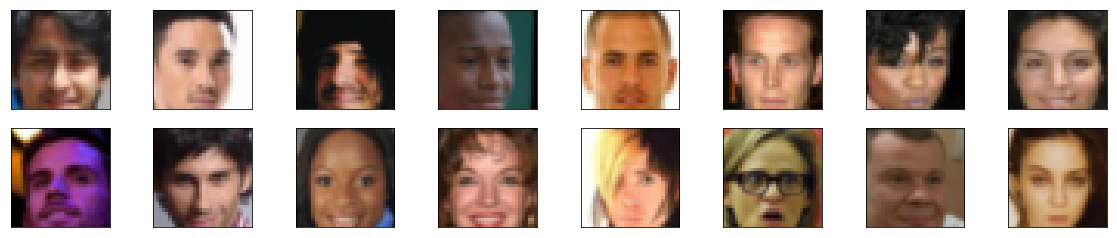

In [10]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [11]:
fig.savefig('image_sets/orig_examples.png')

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [12]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
     # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x
    

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9294)
Max:  tensor(0.9843)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [14]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [15]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 2x2 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        
        # set dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = self.dropout(out)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = self.dropout(out)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = self.dropout(out)
        out = F.leaky_relu(self.conv4(out), 0.2)
        # flatten
        out = out.view(-1, self.conv_dim*8*2*2)
        out = self.dropout(out)
        # final output layer
        out = self.fc(out)        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [16]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


In [17]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv3 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        
        # set dropout layer
        self.dropout = nn.Dropout(p=0.5)
        

    def forward(self, x):
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2) # (batch_size, depth, 2, 2)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = self.dropout(out)
        out = F.relu(self.t_conv2(out))
        out = self.dropout(out)
        out = F.relu(self.t_conv3(out))
        out = self.dropout(out)
        # last layer + tanh activation
        out = self.t_conv4(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [18]:
# takes in a module and applies the specified weight initialization
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and classname.find('Linear') != -1:
        m.weight.data.normal_(0, 0.02)
        m.bias.data.fill_(0)
    
    elif hasattr(m, 'weight') and classname.find('Conv') != -1:
        m.weight.data.normal_(0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [20]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [22]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        labels = torch.ones(batch_size)*0.9 # smooth, real labels = 0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models.

In [23]:
# Create optimizers for the discriminator and generator
def optimizer(lr):
    d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
    g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

    return d_optimizer, g_optimizer

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [24]:
# save chosen hyperparameters of the actual training run to an excel file
def save_data(index, losses, batch_size):
    losses = np.array(losses)
    
    # Export Loss as Dataframe
    idx = range(len(losses.T[0]))
    d = {'Discriminator': losses.T[0], 'Generator': losses.T[1]}
    loss_df = pd.DataFrame(data=d, index = idx)
    train_number = train_n + index
    loss_df.to_excel('training_results/train_' + str(train_number) +'_'+ param + ".xlsx")
    
    # Export hyperparameters
    hyper_params = {'batch_size': batch_size,
                'img_size': img_size,
                'deconv-layers': 3,
                'conv-layers': 3,
                'd_conv_dim': d_conv_dim,
                'g_conv_dim': g_conv_dim,
                'z_size': z_size,
                'lr': lr,
                'beta1': beta1,
                'beta2': beta2,
                'dropout': 'no',
                'n_epochs': n_epochs
                }
    hyper_param_df = pd.DataFrame.from_dict(hyper_params, orient='index')
    hyper_param_df.to_excel('training_results/train_' + str(train_number) +'_'+ param + "_hyper_param.xlsx")
    print(hyper_params)

In [25]:
# plot the training losses of Discriminator and Generator for the actual training run
def plot_training_loss(losses):
    print('Plot Loss')
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
    plt.show()

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(index, epoch=-1):
    print('View Samples')
    train_number = train_n + index
    # Load samples from generator, taken while training
    with open('training_results_pkl/train_' + str(train_number) +'_'+ param + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    plt.show()

In [27]:
def train(D, G,  n_epochs, index=0, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    train_number = train_n + index
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    with active_session():
        for epoch in range(n_epochs):

            # batch training loop
            for batch_i, (real_images, _) in enumerate(celeba_train_loader):

                batch_size = real_images.size(0)
                real_images = scale(real_images)

                # ===============================================
                #         YOUR CODE HERE: TRAIN THE NETWORKS
                # ===============================================

                # ============================================
                #            TRAIN THE DISCRIMINATOR
                # ============================================

                d_optimizer.zero_grad()

                # 1. Train with real images

                # Compute the discriminator losses on real images 
                if train_on_gpu:
                    real_images = real_images.cuda()

                D_real = D(real_images)
                d_real_loss = real_loss(D_real)

                # 2. Train with fake images

                # Generate fake images
                z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                z = torch.from_numpy(z).float()
                # move x to GPU, if available
                if train_on_gpu:
                    z = z.cuda()
                fake_images = G(z)

                # Compute the discriminator losses on fake images            
                D_fake = D(fake_images)
                d_fake_loss = fake_loss(D_fake)

                # add up loss and perform backprop
                d_loss = d_real_loss + d_fake_loss
                d_loss.backward()
                d_optimizer.step()


                # =========================================
                #            TRAIN THE GENERATOR
                # =========================================
                g_optimizer.zero_grad()

                # 1. Train with fake images and flipped labels

                # Generate fake images
                z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                z = torch.from_numpy(z).float()
                if train_on_gpu:
                    z = z.cuda()
                fake_images = G(z)

                # Compute the discriminator losses on fake images 
                # using flipped labels!
                D_fake = D(fake_images)
                g_loss = real_loss(D_fake) # use real loss to flip labels

                # perform backprop
                g_loss.backward()
                g_optimizer.step()


                # ===============================================
                #              END OF YOUR CODE
                # ===============================================

                # Print some loss stats
                if batch_i % print_every == 0:
                    # append discriminator loss and generator loss
                    losses.append((d_loss.item(), g_loss.item()))
                    # print discriminator and generator loss
                    print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                            epoch+1, n_epochs, d_loss.item(), g_loss.item()))


            ## AFTER EACH EPOCH##    
            # this code assumes your generator is named G, feel free to change the name
            # generate and save sample, fake images
            G.eval() # for generating samples
            samples_z = G(fixed_z)
            samples.append(samples_z)
            G.train() # back to training mode

    # Save training generator samples
    with open('training_results_pkl/train_' + str(train_number) +'_'+ param + '_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [28]:
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])
n_epochs=1
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
# losses = train(D, G, n_epochs=n_epochs)

"\nDON'T MODIFY ANYTHING IN THIS CELL\n"

Build Network
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4

Epoch [    3/  100] | d_loss: 0.0941 | g_loss: 2.1856
Epoch [    3/  100] | d_loss: 0.2151 | g_loss: 3.9828
Epoch [    3/  100] | d_loss: 0.3075 | g_loss: 3.7148
Epoch [    3/  100] | d_loss: 0.9140 | g_loss: 1.6541
Epoch [    3/  100] | d_loss: 0.1696 | g_loss: 4.1953
Epoch [    3/  100] | d_loss: 0.2491 | g_loss: 4.5186
Epoch [    3/  100] | d_loss: 0.2482 | g_loss: 5.7543
Epoch [    3/  100] | d_loss: 0.1069 | g_loss: 2.3942
Epoch [    3/  100] | d_loss: 0.0648 | g_loss: 8.1534
Epoch [    3/  100] | d_loss: 0.1688 | g_loss: 4.2746
Epoch [    3/  100] | d_loss: 0.1534 | g_loss: 3.4283
Epoch [    3/  100] | d_loss: 0.0610 | g_loss: 3.7602
Epoch [    3/  100] | d_loss: 0.2273 | g_loss: 5.5042
Epoch [    3/  100] | d_loss: 0.0657 | g_loss: 1.9339
Epoch [    3/  100] | d_loss: 0.5252 | g_loss: 1.6877
Epoch [    3/  100] | d_loss: 0.3832 | g_loss: 6.4176
Epoch [    3/  100] | d_loss: 0.2318 | g_loss: 3.6729
Epoch [    3/  100] | d_loss: 1.8239 | g_loss: 5.9193
Epoch [    3/  100] | d_loss

Epoch [    5/  100] | d_loss: 0.0379 | g_loss: 3.7264
Epoch [    5/  100] | d_loss: 0.1892 | g_loss: 3.1181
Epoch [    5/  100] | d_loss: 0.1420 | g_loss: 9.1926
Epoch [    5/  100] | d_loss: 0.2311 | g_loss: 7.8841
Epoch [    5/  100] | d_loss: 0.1615 | g_loss: 3.1177
Epoch [    5/  100] | d_loss: 0.0943 | g_loss: 3.7614
Epoch [    5/  100] | d_loss: 0.0216 | g_loss: 3.2532
Epoch [    5/  100] | d_loss: 0.0516 | g_loss: 6.6019
Epoch [    5/  100] | d_loss: 0.0237 | g_loss: 7.1805
Epoch [    5/  100] | d_loss: 0.0267 | g_loss: 4.2608
Epoch [    5/  100] | d_loss: 0.0524 | g_loss: 2.0355
Epoch [    5/  100] | d_loss: 0.0944 | g_loss: 7.2471
Epoch [    5/  100] | d_loss: 0.3652 | g_loss: 5.9750
Epoch [    6/  100] | d_loss: 2.0440 | g_loss: 10.4792
Epoch [    6/  100] | d_loss: 0.1124 | g_loss: 6.8937
Epoch [    6/  100] | d_loss: 0.6225 | g_loss: 1.0600
Epoch [    6/  100] | d_loss: 0.0175 | g_loss: 5.7055
Epoch [    6/  100] | d_loss: 0.0541 | g_loss: 6.8112
Epoch [    6/  100] | d_los

Epoch [    8/  100] | d_loss: 0.0041 | g_loss: 3.9821
Epoch [    8/  100] | d_loss: 0.0043 | g_loss: 12.6246
Epoch [    8/  100] | d_loss: 0.0743 | g_loss: 2.9866
Epoch [    8/  100] | d_loss: 0.0014 | g_loss: 9.3904
Epoch [    8/  100] | d_loss: 0.0118 | g_loss: 5.3822
Epoch [    8/  100] | d_loss: 0.0240 | g_loss: 5.5079
Epoch [    8/  100] | d_loss: 0.0221 | g_loss: 4.4722
Epoch [    8/  100] | d_loss: 0.9905 | g_loss: 5.7830
Epoch [    8/  100] | d_loss: 0.0158 | g_loss: 5.1963
Epoch [    8/  100] | d_loss: 0.0020 | g_loss: 7.4652
Epoch [    8/  100] | d_loss: 0.0049 | g_loss: 4.7537
Epoch [    8/  100] | d_loss: 0.0027 | g_loss: 5.5817
Epoch [    8/  100] | d_loss: 0.0498 | g_loss: 3.7822
Epoch [    8/  100] | d_loss: 0.4625 | g_loss: 7.8322
Epoch [    8/  100] | d_loss: 0.0397 | g_loss: 6.9413
Epoch [    8/  100] | d_loss: 1.5985 | g_loss: 6.8967
Epoch [    8/  100] | d_loss: 0.0187 | g_loss: 5.3095
Epoch [    8/  100] | d_loss: 0.0048 | g_loss: 10.2873
Epoch [    8/  100] | d_lo

Epoch [   11/  100] | d_loss: 0.0026 | g_loss: 7.4999
Epoch [   11/  100] | d_loss: 0.0075 | g_loss: 14.9252
Epoch [   11/  100] | d_loss: 0.0136 | g_loss: 3.1595
Epoch [   11/  100] | d_loss: 0.0156 | g_loss: 6.2755
Epoch [   11/  100] | d_loss: 0.3116 | g_loss: 2.9841
Epoch [   11/  100] | d_loss: 0.0141 | g_loss: 5.3030
Epoch [   11/  100] | d_loss: 0.0544 | g_loss: 2.1671
Epoch [   11/  100] | d_loss: 0.0021 | g_loss: 8.3947
Epoch [   11/  100] | d_loss: 0.0128 | g_loss: 9.2379
Epoch [   11/  100] | d_loss: 0.0070 | g_loss: 8.6077
Epoch [   11/  100] | d_loss: 0.0002 | g_loss: 4.8991
Epoch [   11/  100] | d_loss: 0.1166 | g_loss: 4.7940
Epoch [   11/  100] | d_loss: 0.0049 | g_loss: 7.9517
Epoch [   11/  100] | d_loss: 0.0063 | g_loss: 6.6876
Epoch [   11/  100] | d_loss: 0.0033 | g_loss: 4.8701
Epoch [   11/  100] | d_loss: 0.0063 | g_loss: 6.0959
Epoch [   11/  100] | d_loss: 0.0013 | g_loss: 2.5818
Epoch [   11/  100] | d_loss: 0.7163 | g_loss: 13.2398
Epoch [   11/  100] | d_lo

Epoch [   13/  100] | d_loss: 0.2062 | g_loss: 7.3405
Epoch [   13/  100] | d_loss: 0.0043 | g_loss: 9.3231
Epoch [   13/  100] | d_loss: 0.0048 | g_loss: 10.9979
Epoch [   13/  100] | d_loss: 0.0374 | g_loss: 4.7851
Epoch [   13/  100] | d_loss: 0.0196 | g_loss: 6.9686
Epoch [   13/  100] | d_loss: 0.0934 | g_loss: 6.4178
Epoch [   13/  100] | d_loss: 0.0131 | g_loss: 7.4366
Epoch [   13/  100] | d_loss: 0.0000 | g_loss: 8.7474
Epoch [   13/  100] | d_loss: 0.0024 | g_loss: 11.8224
Epoch [   13/  100] | d_loss: 0.0078 | g_loss: 5.3832
Epoch [   13/  100] | d_loss: 0.0263 | g_loss: 8.5636
Epoch [   13/  100] | d_loss: 0.0156 | g_loss: 3.0981
Epoch [   13/  100] | d_loss: 0.2795 | g_loss: 8.0232
Epoch [   14/  100] | d_loss: 0.0070 | g_loss: 4.2965
Epoch [   14/  100] | d_loss: 0.0160 | g_loss: 7.3541
Epoch [   14/  100] | d_loss: 0.2528 | g_loss: 16.7749
Epoch [   14/  100] | d_loss: 0.0608 | g_loss: 14.2291
Epoch [   14/  100] | d_loss: 0.5214 | g_loss: 3.7985
Epoch [   14/  100] | d_

Epoch [   16/  100] | d_loss: 0.0051 | g_loss: 4.8546
Epoch [   16/  100] | d_loss: 0.1371 | g_loss: 10.8522
Epoch [   16/  100] | d_loss: 0.0015 | g_loss: 7.8005
Epoch [   16/  100] | d_loss: 0.0524 | g_loss: 6.4109
Epoch [   16/  100] | d_loss: 0.0470 | g_loss: 8.2979
Epoch [   16/  100] | d_loss: 0.0103 | g_loss: 7.5031
Epoch [   16/  100] | d_loss: 0.0025 | g_loss: 5.7967
Epoch [   16/  100] | d_loss: 0.0001 | g_loss: 7.9935
Epoch [   16/  100] | d_loss: 0.0081 | g_loss: 8.6266
Epoch [   16/  100] | d_loss: 0.0520 | g_loss: 5.3393
Epoch [   16/  100] | d_loss: 0.0178 | g_loss: 6.4575
Epoch [   16/  100] | d_loss: 0.0569 | g_loss: 10.0308
Epoch [   16/  100] | d_loss: 0.2040 | g_loss: 3.5411
Epoch [   16/  100] | d_loss: 0.0196 | g_loss: 6.7157
Epoch [   16/  100] | d_loss: 0.0129 | g_loss: 5.9651
Epoch [   16/  100] | d_loss: 0.0101 | g_loss: 10.0643
Epoch [   16/  100] | d_loss: 0.0338 | g_loss: 8.1415
Epoch [   16/  100] | d_loss: 0.0269 | g_loss: 7.5602
Epoch [   16/  100] | d_l

Epoch [   19/  100] | d_loss: 0.0446 | g_loss: 8.7149
Epoch [   19/  100] | d_loss: 0.0002 | g_loss: 5.9085
Epoch [   19/  100] | d_loss: 0.0085 | g_loss: 9.6630
Epoch [   19/  100] | d_loss: 0.0099 | g_loss: 6.4837
Epoch [   19/  100] | d_loss: 0.0338 | g_loss: 7.9472
Epoch [   19/  100] | d_loss: 0.0022 | g_loss: 6.8910
Epoch [   19/  100] | d_loss: 0.0186 | g_loss: 10.9513
Epoch [   19/  100] | d_loss: 1.0002 | g_loss: 6.7347
Epoch [   19/  100] | d_loss: 0.0026 | g_loss: 6.6427
Epoch [   19/  100] | d_loss: 0.0001 | g_loss: 10.2305
Epoch [   19/  100] | d_loss: 0.0011 | g_loss: 5.5731
Epoch [   19/  100] | d_loss: 0.0005 | g_loss: 5.0548
Epoch [   19/  100] | d_loss: 0.0738 | g_loss: 8.7104
Epoch [   19/  100] | d_loss: 0.0060 | g_loss: 8.0437
Epoch [   19/  100] | d_loss: 0.0009 | g_loss: 10.0999
Epoch [   19/  100] | d_loss: 0.0011 | g_loss: 11.1033
Epoch [   19/  100] | d_loss: 0.0004 | g_loss: 8.4229
Epoch [   19/  100] | d_loss: 0.0017 | g_loss: 12.3769
Epoch [   19/  100] | d

Epoch [   21/  100] | d_loss: 0.0130 | g_loss: 5.9028
Epoch [   21/  100] | d_loss: 0.0004 | g_loss: 9.8998
Epoch [   21/  100] | d_loss: 0.0337 | g_loss: 8.5252
Epoch [   21/  100] | d_loss: 0.0125 | g_loss: 9.7483
Epoch [   21/  100] | d_loss: 0.0049 | g_loss: 12.6045
Epoch [   21/  100] | d_loss: 0.0055 | g_loss: 8.3687
Epoch [   21/  100] | d_loss: 0.0075 | g_loss: 7.6212
Epoch [   21/  100] | d_loss: 0.0043 | g_loss: 8.0254
Epoch [   21/  100] | d_loss: 0.0097 | g_loss: 4.8821
Epoch [   21/  100] | d_loss: 0.0003 | g_loss: 4.3303
Epoch [   21/  100] | d_loss: 0.0006 | g_loss: 6.3079
Epoch [   21/  100] | d_loss: 0.0115 | g_loss: 6.5289
Epoch [   21/  100] | d_loss: 0.0010 | g_loss: 5.4387
Epoch [   21/  100] | d_loss: 0.0040 | g_loss: 10.3273
Epoch [   21/  100] | d_loss: 0.0646 | g_loss: 1.3881
Epoch [   22/  100] | d_loss: 0.0754 | g_loss: 11.4110
Epoch [   22/  100] | d_loss: 0.0027 | g_loss: 8.1323
Epoch [   22/  100] | d_loss: 0.0431 | g_loss: 5.9734
Epoch [   22/  100] | d_l

Epoch [   24/  100] | d_loss: 0.7538 | g_loss: 4.2980
Epoch [   24/  100] | d_loss: 0.0000 | g_loss: 6.8945
Epoch [   24/  100] | d_loss: 0.0030 | g_loss: 8.1115
Epoch [   24/  100] | d_loss: 0.0001 | g_loss: 8.8441
Epoch [   24/  100] | d_loss: 0.0040 | g_loss: 7.1453
Epoch [   24/  100] | d_loss: 0.0035 | g_loss: 10.8381
Epoch [   24/  100] | d_loss: 0.0010 | g_loss: 8.3191
Epoch [   24/  100] | d_loss: 0.0036 | g_loss: 8.5150
Epoch [   24/  100] | d_loss: 0.0000 | g_loss: 9.3836
Epoch [   24/  100] | d_loss: 0.0244 | g_loss: 13.5324
Epoch [   24/  100] | d_loss: 0.0106 | g_loss: 9.9629
Epoch [   24/  100] | d_loss: 0.0155 | g_loss: 8.1887
Epoch [   24/  100] | d_loss: 0.0035 | g_loss: 7.7117
Epoch [   24/  100] | d_loss: 0.0894 | g_loss: 13.3756
Epoch [   24/  100] | d_loss: 0.0012 | g_loss: 8.5026
Epoch [   24/  100] | d_loss: 0.0096 | g_loss: 7.7360
Epoch [   24/  100] | d_loss: 0.0516 | g_loss: 10.6688
Epoch [   24/  100] | d_loss: 0.0012 | g_loss: 9.0633
Epoch [   24/  100] | d_

Epoch [   27/  100] | d_loss: 0.0001 | g_loss: 9.0506
Epoch [   27/  100] | d_loss: 0.0029 | g_loss: 9.5128
Epoch [   27/  100] | d_loss: 0.0004 | g_loss: 10.3028
Epoch [   27/  100] | d_loss: 0.0042 | g_loss: 5.5627
Epoch [   27/  100] | d_loss: 0.0103 | g_loss: 12.6199
Epoch [   27/  100] | d_loss: 0.0042 | g_loss: 8.8687
Epoch [   27/  100] | d_loss: 0.0002 | g_loss: 9.6575
Epoch [   27/  100] | d_loss: 0.0164 | g_loss: 10.8624
Epoch [   27/  100] | d_loss: 0.0035 | g_loss: 13.6767
Epoch [   27/  100] | d_loss: 0.0001 | g_loss: 14.5524
Epoch [   27/  100] | d_loss: 0.0009 | g_loss: 9.2393
Epoch [   27/  100] | d_loss: 0.0027 | g_loss: 9.0785
Epoch [   27/  100] | d_loss: 0.0023 | g_loss: 7.1076
Epoch [   27/  100] | d_loss: 0.0022 | g_loss: 10.9692
Epoch [   27/  100] | d_loss: 0.0007 | g_loss: 9.2176
Epoch [   27/  100] | d_loss: 0.0228 | g_loss: 11.6451
Epoch [   27/  100] | d_loss: 0.0224 | g_loss: 12.2805
Epoch [   27/  100] | d_loss: 0.0056 | g_loss: 9.8411
Epoch [   27/  100] 

Epoch [   29/  100] | d_loss: 0.0000 | g_loss: 10.7002
Epoch [   29/  100] | d_loss: 0.0072 | g_loss: 8.3337
Epoch [   29/  100] | d_loss: 0.0002 | g_loss: 8.2908
Epoch [   29/  100] | d_loss: 0.0285 | g_loss: 4.8955
Epoch [   29/  100] | d_loss: 0.0002 | g_loss: 7.6619
Epoch [   29/  100] | d_loss: 0.0010 | g_loss: 11.4912
Epoch [   29/  100] | d_loss: 0.0014 | g_loss: 11.0206
Epoch [   29/  100] | d_loss: 0.0013 | g_loss: 12.0968
Epoch [   29/  100] | d_loss: 0.0012 | g_loss: 8.3484
Epoch [   29/  100] | d_loss: 0.0219 | g_loss: 4.9461
Epoch [   29/  100] | d_loss: 0.0675 | g_loss: 12.0775
Epoch [   29/  100] | d_loss: 0.1304 | g_loss: 6.7782
Epoch [   29/  100] | d_loss: 0.0003 | g_loss: 5.1143
Epoch [   29/  100] | d_loss: 0.0002 | g_loss: 10.9208
Epoch [   29/  100] | d_loss: 0.0041 | g_loss: 7.2215
Epoch [   29/  100] | d_loss: 0.0070 | g_loss: 7.8921
Epoch [   29/  100] | d_loss: 0.0008 | g_loss: 10.5131
Epoch [   29/  100] | d_loss: 0.1840 | g_loss: 9.5179
Epoch [   30/  100] |

Epoch [   32/  100] | d_loss: 0.0004 | g_loss: 8.7117
Epoch [   32/  100] | d_loss: 0.0004 | g_loss: 7.1354
Epoch [   32/  100] | d_loss: 0.0003 | g_loss: 13.9097
Epoch [   32/  100] | d_loss: 0.0000 | g_loss: 10.2108
Epoch [   32/  100] | d_loss: 0.0001 | g_loss: 9.1001
Epoch [   32/  100] | d_loss: 0.0003 | g_loss: 13.7287
Epoch [   32/  100] | d_loss: 0.0038 | g_loss: 7.4329
Epoch [   32/  100] | d_loss: 0.0062 | g_loss: 12.2133
Epoch [   32/  100] | d_loss: 0.0002 | g_loss: 14.7677
Epoch [   32/  100] | d_loss: 0.2881 | g_loss: 15.5410
Epoch [   32/  100] | d_loss: 0.0039 | g_loss: 3.7474
Epoch [   32/  100] | d_loss: 0.0133 | g_loss: 9.8284
Epoch [   32/  100] | d_loss: 0.0095 | g_loss: 8.0528
Epoch [   32/  100] | d_loss: 0.0010 | g_loss: 11.8612
Epoch [   32/  100] | d_loss: 0.0448 | g_loss: 9.5695
Epoch [   32/  100] | d_loss: 0.1555 | g_loss: 8.8092
Epoch [   32/  100] | d_loss: 0.0231 | g_loss: 8.1332
Epoch [   32/  100] | d_loss: 0.0159 | g_loss: 7.3070
Epoch [   32/  100] |

Epoch [   34/  100] | d_loss: 0.0048 | g_loss: 8.8590
Epoch [   35/  100] | d_loss: 0.0006 | g_loss: 5.9473
Epoch [   35/  100] | d_loss: 0.0081 | g_loss: 14.5119
Epoch [   35/  100] | d_loss: 0.0000 | g_loss: 8.5277
Epoch [   35/  100] | d_loss: 0.0028 | g_loss: 12.7734
Epoch [   35/  100] | d_loss: 0.0039 | g_loss: 10.1730
Epoch [   35/  100] | d_loss: 0.0037 | g_loss: 12.3890
Epoch [   35/  100] | d_loss: 0.0610 | g_loss: 11.6644
Epoch [   35/  100] | d_loss: 0.0090 | g_loss: 12.6681
Epoch [   35/  100] | d_loss: 0.0001 | g_loss: 12.7274
Epoch [   35/  100] | d_loss: 0.0003 | g_loss: 11.4200
Epoch [   35/  100] | d_loss: 0.0027 | g_loss: 14.0427
Epoch [   35/  100] | d_loss: 0.0029 | g_loss: 8.7154
Epoch [   35/  100] | d_loss: 0.0021 | g_loss: 6.9580
Epoch [   35/  100] | d_loss: 0.0000 | g_loss: 7.6319
Epoch [   35/  100] | d_loss: 0.0030 | g_loss: 8.1952
Epoch [   35/  100] | d_loss: 0.0065 | g_loss: 12.0364
Epoch [   35/  100] | d_loss: 0.0009 | g_loss: 10.6828
Epoch [   35/  10

Epoch [   37/  100] | d_loss: 0.0013 | g_loss: 13.3200
Epoch [   37/  100] | d_loss: 0.0023 | g_loss: 9.7597
Epoch [   37/  100] | d_loss: 0.8732 | g_loss: 9.9849
Epoch [   37/  100] | d_loss: 0.0071 | g_loss: 9.4827
Epoch [   37/  100] | d_loss: 0.0239 | g_loss: 8.8153
Epoch [   37/  100] | d_loss: 1.1508 | g_loss: 21.0377
Epoch [   37/  100] | d_loss: 0.0004 | g_loss: 8.9031
Epoch [   37/  100] | d_loss: 0.0003 | g_loss: 8.8401
Epoch [   37/  100] | d_loss: 0.0038 | g_loss: 5.9342
Epoch [   37/  100] | d_loss: 0.0023 | g_loss: 12.7370
Epoch [   37/  100] | d_loss: 0.0047 | g_loss: 14.5894
Epoch [   37/  100] | d_loss: 0.0009 | g_loss: 14.4679
Epoch [   37/  100] | d_loss: 0.0005 | g_loss: 9.3768
Epoch [   37/  100] | d_loss: 0.0912 | g_loss: 8.6087
Epoch [   37/  100] | d_loss: 0.0004 | g_loss: 6.5045
Epoch [   37/  100] | d_loss: 0.0045 | g_loss: 8.1542
Epoch [   37/  100] | d_loss: 0.0003 | g_loss: 14.3074
Epoch [   37/  100] | d_loss: 0.0163 | g_loss: 14.6391
Epoch [   37/  100] |

Epoch [   40/  100] | d_loss: 0.0287 | g_loss: 9.5866
Epoch [   40/  100] | d_loss: 0.0002 | g_loss: 10.2865
Epoch [   40/  100] | d_loss: 0.0062 | g_loss: 13.9037
Epoch [   40/  100] | d_loss: 0.0037 | g_loss: 8.8269
Epoch [   40/  100] | d_loss: 0.0061 | g_loss: 14.3819
Epoch [   40/  100] | d_loss: 0.0004 | g_loss: 5.3119
Epoch [   40/  100] | d_loss: 0.0246 | g_loss: 8.0677
Epoch [   40/  100] | d_loss: 0.0001 | g_loss: 9.7092
Epoch [   40/  100] | d_loss: 0.0043 | g_loss: 10.2602
Epoch [   40/  100] | d_loss: 0.2395 | g_loss: 9.1498
Epoch [   40/  100] | d_loss: 0.0002 | g_loss: 10.1623
Epoch [   40/  100] | d_loss: 0.0007 | g_loss: 11.2309
Epoch [   40/  100] | d_loss: 0.0001 | g_loss: 10.3190
Epoch [   40/  100] | d_loss: 0.0001 | g_loss: 10.9095
Epoch [   40/  100] | d_loss: 0.0000 | g_loss: 11.0232
Epoch [   40/  100] | d_loss: 0.0007 | g_loss: 13.5017
Epoch [   40/  100] | d_loss: 0.0053 | g_loss: 13.4435
Epoch [   40/  100] | d_loss: 0.0009 | g_loss: 7.4806
Epoch [   40/  10

Epoch [   42/  100] | d_loss: 0.0016 | g_loss: 10.7021
Epoch [   42/  100] | d_loss: 0.0006 | g_loss: 8.4955
Epoch [   42/  100] | d_loss: 0.0419 | g_loss: 7.9204
Epoch [   42/  100] | d_loss: 0.0076 | g_loss: 9.3456
Epoch [   43/  100] | d_loss: 0.0007 | g_loss: 12.8466
Epoch [   43/  100] | d_loss: 0.0007 | g_loss: 4.7897
Epoch [   43/  100] | d_loss: 0.0041 | g_loss: 12.9674
Epoch [   43/  100] | d_loss: 0.0000 | g_loss: 12.4902
Epoch [   43/  100] | d_loss: 0.0006 | g_loss: 14.3856
Epoch [   43/  100] | d_loss: 0.0016 | g_loss: 11.5385
Epoch [   43/  100] | d_loss: 0.0001 | g_loss: 11.2655
Epoch [   43/  100] | d_loss: 0.0005 | g_loss: 12.9610
Epoch [   43/  100] | d_loss: 0.0000 | g_loss: 7.4364
Epoch [   43/  100] | d_loss: 0.0000 | g_loss: 10.6794
Epoch [   43/  100] | d_loss: 0.0029 | g_loss: 12.0862
Epoch [   43/  100] | d_loss: 0.0024 | g_loss: 14.5313
Epoch [   43/  100] | d_loss: 0.0018 | g_loss: 7.3536
Epoch [   43/  100] | d_loss: 0.0084 | g_loss: 13.5496
Epoch [   43/  1

Epoch [   45/  100] | d_loss: 0.0002 | g_loss: 6.4123
Epoch [   45/  100] | d_loss: 0.0013 | g_loss: 9.4946
Epoch [   45/  100] | d_loss: 0.0008 | g_loss: 13.0604
Epoch [   45/  100] | d_loss: 0.0000 | g_loss: 10.2682
Epoch [   45/  100] | d_loss: 0.0275 | g_loss: 15.9770
Epoch [   45/  100] | d_loss: 0.0022 | g_loss: 5.3707
Epoch [   45/  100] | d_loss: 0.0000 | g_loss: 11.7298
Epoch [   45/  100] | d_loss: 0.0026 | g_loss: 13.8566
Epoch [   45/  100] | d_loss: 0.0009 | g_loss: 9.0709
Epoch [   45/  100] | d_loss: 0.0045 | g_loss: 7.7213
Epoch [   45/  100] | d_loss: 0.0026 | g_loss: 10.2576
Epoch [   45/  100] | d_loss: 0.0011 | g_loss: 7.3464
Epoch [   45/  100] | d_loss: 0.0007 | g_loss: 6.3057
Epoch [   45/  100] | d_loss: 0.0011 | g_loss: 11.1930
Epoch [   45/  100] | d_loss: 0.0000 | g_loss: 10.3881
Epoch [   45/  100] | d_loss: 0.0012 | g_loss: 7.9891
Epoch [   45/  100] | d_loss: 0.0001 | g_loss: 11.6762
Epoch [   45/  100] | d_loss: 0.0003 | g_loss: 9.3786
Epoch [   45/  100]

Epoch [   48/  100] | d_loss: 0.0006 | g_loss: 4.2241
Epoch [   48/  100] | d_loss: 0.0085 | g_loss: 9.6380
Epoch [   48/  100] | d_loss: 0.5839 | g_loss: 20.7202
Epoch [   48/  100] | d_loss: 0.0306 | g_loss: 14.1297
Epoch [   48/  100] | d_loss: 0.0082 | g_loss: 10.2890
Epoch [   48/  100] | d_loss: 0.0020 | g_loss: 10.9326
Epoch [   48/  100] | d_loss: 0.0002 | g_loss: 15.6310
Epoch [   48/  100] | d_loss: 0.0047 | g_loss: 5.4257
Epoch [   48/  100] | d_loss: 0.0001 | g_loss: 9.6315
Epoch [   48/  100] | d_loss: 0.0014 | g_loss: 10.4798
Epoch [   48/  100] | d_loss: 0.0001 | g_loss: 13.4709
Epoch [   48/  100] | d_loss: 0.0017 | g_loss: 8.3505
Epoch [   48/  100] | d_loss: 0.0000 | g_loss: 11.8382
Epoch [   48/  100] | d_loss: 0.0284 | g_loss: 7.1501
Epoch [   48/  100] | d_loss: 0.0034 | g_loss: 19.1380
Epoch [   48/  100] | d_loss: 0.0010 | g_loss: 13.9957
Epoch [   48/  100] | d_loss: 0.0004 | g_loss: 16.5247
Epoch [   48/  100] | d_loss: 0.0000 | g_loss: 15.0890
Epoch [   48/  1

Epoch [   50/  100] | d_loss: 0.0011 | g_loss: 6.3663
Epoch [   50/  100] | d_loss: 0.0009 | g_loss: 8.4166
Epoch [   50/  100] | d_loss: 0.0043 | g_loss: 12.4141
Epoch [   50/  100] | d_loss: 0.0004 | g_loss: 10.6555
Epoch [   50/  100] | d_loss: 0.0345 | g_loss: 8.1543
Epoch [   50/  100] | d_loss: 0.0165 | g_loss: 13.8702
Epoch [   50/  100] | d_loss: 0.2530 | g_loss: 16.2057
Epoch [   50/  100] | d_loss: 0.0002 | g_loss: 13.9039
Epoch [   51/  100] | d_loss: 0.0000 | g_loss: 10.9228
Epoch [   51/  100] | d_loss: 0.0017 | g_loss: 11.2786
Epoch [   51/  100] | d_loss: 0.0001 | g_loss: 12.1216
Epoch [   51/  100] | d_loss: 0.0100 | g_loss: 8.6212
Epoch [   51/  100] | d_loss: 0.0001 | g_loss: 14.7574
Epoch [   51/  100] | d_loss: 0.0005 | g_loss: 11.8602
Epoch [   51/  100] | d_loss: 0.0001 | g_loss: 20.2291
Epoch [   51/  100] | d_loss: 0.0002 | g_loss: 12.1787
Epoch [   51/  100] | d_loss: 0.0023 | g_loss: 11.0208
Epoch [   51/  100] | d_loss: 0.0001 | g_loss: 17.6137
Epoch [   51/ 

Epoch [   53/  100] | d_loss: 0.0008 | g_loss: 16.0819
Epoch [   53/  100] | d_loss: 0.0001 | g_loss: 12.8147
Epoch [   53/  100] | d_loss: 0.0020 | g_loss: 6.7610
Epoch [   53/  100] | d_loss: 0.0002 | g_loss: 11.0820
Epoch [   53/  100] | d_loss: 0.0006 | g_loss: 12.4862
Epoch [   53/  100] | d_loss: 0.0015 | g_loss: 12.7413
Epoch [   53/  100] | d_loss: 0.0000 | g_loss: 16.8976
Epoch [   53/  100] | d_loss: 0.0009 | g_loss: 9.6024
Epoch [   53/  100] | d_loss: 0.0022 | g_loss: 14.1467
Epoch [   53/  100] | d_loss: 0.0010 | g_loss: 14.0807
Epoch [   53/  100] | d_loss: 0.0175 | g_loss: 22.3105
Epoch [   53/  100] | d_loss: 0.0019 | g_loss: 12.0625
Epoch [   53/  100] | d_loss: 0.0039 | g_loss: 13.3878
Epoch [   53/  100] | d_loss: 0.0003 | g_loss: 9.6159
Epoch [   53/  100] | d_loss: 0.0046 | g_loss: 17.1794
Epoch [   53/  100] | d_loss: 0.0002 | g_loss: 4.7761
Epoch [   53/  100] | d_loss: 0.0000 | g_loss: 7.7652
Epoch [   53/  100] | d_loss: 0.0001 | g_loss: 5.6010
Epoch [   53/  1

Epoch [   56/  100] | d_loss: 0.0001 | g_loss: 11.2527
Epoch [   56/  100] | d_loss: 0.0000 | g_loss: 16.3426
Epoch [   56/  100] | d_loss: 0.0220 | g_loss: 12.7190
Epoch [   56/  100] | d_loss: 0.0008 | g_loss: 9.9412
Epoch [   56/  100] | d_loss: 0.0018 | g_loss: 17.8034
Epoch [   56/  100] | d_loss: 0.0000 | g_loss: 8.2293
Epoch [   56/  100] | d_loss: 0.0000 | g_loss: 8.1352
Epoch [   56/  100] | d_loss: 0.0001 | g_loss: 11.1794
Epoch [   56/  100] | d_loss: 0.0004 | g_loss: 13.9095
Epoch [   56/  100] | d_loss: 0.0002 | g_loss: 6.2509
Epoch [   56/  100] | d_loss: 0.0026 | g_loss: 7.7534
Epoch [   56/  100] | d_loss: 0.0000 | g_loss: 10.6095
Epoch [   56/  100] | d_loss: 0.0038 | g_loss: 7.3871
Epoch [   56/  100] | d_loss: 0.1234 | g_loss: 15.9040
Epoch [   56/  100] | d_loss: 0.0030 | g_loss: 6.5496
Epoch [   56/  100] | d_loss: 0.1005 | g_loss: 14.0310
Epoch [   56/  100] | d_loss: 0.0002 | g_loss: 10.1841
Epoch [   56/  100] | d_loss: 0.0016 | g_loss: 11.2476
Epoch [   56/  10

Epoch [   58/  100] | d_loss: 0.0000 | g_loss: 14.1681
Epoch [   58/  100] | d_loss: 0.0001 | g_loss: 14.1056
Epoch [   58/  100] | d_loss: 0.0001 | g_loss: 13.9595
Epoch [   58/  100] | d_loss: 0.0016 | g_loss: 12.2890
Epoch [   58/  100] | d_loss: 0.0002 | g_loss: 11.4837
Epoch [   58/  100] | d_loss: 0.0001 | g_loss: 14.8121
Epoch [   58/  100] | d_loss: 0.0001 | g_loss: 9.4724
Epoch [   58/  100] | d_loss: 0.0000 | g_loss: 9.3040
Epoch [   58/  100] | d_loss: 0.0000 | g_loss: 11.2211
Epoch [   58/  100] | d_loss: 0.0225 | g_loss: 12.8073
Epoch [   58/  100] | d_loss: 0.0000 | g_loss: 9.0800
Epoch [   58/  100] | d_loss: 0.4511 | g_loss: 3.0876
Epoch [   58/  100] | d_loss: 0.0001 | g_loss: 10.8837
Epoch [   59/  100] | d_loss: 0.0030 | g_loss: 15.8532
Epoch [   59/  100] | d_loss: 0.0026 | g_loss: 18.4323
Epoch [   59/  100] | d_loss: 0.0023 | g_loss: 9.2454
Epoch [   59/  100] | d_loss: 0.0004 | g_loss: 11.6355
Epoch [   59/  100] | d_loss: 0.0012 | g_loss: 12.0337
Epoch [   59/  

Epoch [   61/  100] | d_loss: 0.0003 | g_loss: 10.0107
Epoch [   61/  100] | d_loss: 0.0000 | g_loss: 13.7507
Epoch [   61/  100] | d_loss: 0.0025 | g_loss: 8.0419
Epoch [   61/  100] | d_loss: 0.0011 | g_loss: 14.0739
Epoch [   61/  100] | d_loss: 0.0002 | g_loss: 8.5633
Epoch [   61/  100] | d_loss: 0.0010 | g_loss: 8.9490
Epoch [   61/  100] | d_loss: 0.0017 | g_loss: 6.5781
Epoch [   61/  100] | d_loss: 0.0022 | g_loss: 14.0981
Epoch [   61/  100] | d_loss: 0.0084 | g_loss: 8.7438
Epoch [   61/  100] | d_loss: 0.0000 | g_loss: 17.3913
Epoch [   61/  100] | d_loss: 0.0000 | g_loss: 14.8051
Epoch [   61/  100] | d_loss: 0.0012 | g_loss: 9.5844
Epoch [   61/  100] | d_loss: 0.0257 | g_loss: 17.6680
Epoch [   61/  100] | d_loss: 0.0000 | g_loss: 12.2837
Epoch [   61/  100] | d_loss: 0.0000 | g_loss: 8.3576
Epoch [   61/  100] | d_loss: 0.0001 | g_loss: 10.9142
Epoch [   61/  100] | d_loss: 0.0002 | g_loss: 9.6455
Epoch [   61/  100] | d_loss: 0.0004 | g_loss: 11.7689
Epoch [   61/  100

Epoch [   64/  100] | d_loss: 0.0021 | g_loss: 11.3694
Epoch [   64/  100] | d_loss: 0.0091 | g_loss: 15.5442
Epoch [   64/  100] | d_loss: 0.0000 | g_loss: 4.8670
Epoch [   64/  100] | d_loss: 0.0050 | g_loss: 15.0309
Epoch [   64/  100] | d_loss: 0.0001 | g_loss: 11.4866
Epoch [   64/  100] | d_loss: 0.0072 | g_loss: 12.9059
Epoch [   64/  100] | d_loss: 0.0000 | g_loss: 15.7899
Epoch [   64/  100] | d_loss: 0.0001 | g_loss: 12.4840
Epoch [   64/  100] | d_loss: 0.5059 | g_loss: 21.1299
Epoch [   64/  100] | d_loss: 0.0006 | g_loss: 15.3129
Epoch [   64/  100] | d_loss: 0.0004 | g_loss: 22.6427
Epoch [   64/  100] | d_loss: 0.0000 | g_loss: 12.3052
Epoch [   64/  100] | d_loss: 0.0004 | g_loss: 17.6729
Epoch [   64/  100] | d_loss: 0.0337 | g_loss: 12.6454
Epoch [   64/  100] | d_loss: 0.0001 | g_loss: 10.0770
Epoch [   64/  100] | d_loss: 0.0006 | g_loss: 12.3170
Epoch [   64/  100] | d_loss: 0.0000 | g_loss: 17.0888
Epoch [   64/  100] | d_loss: 0.0000 | g_loss: 13.5857
Epoch [   6

Epoch [   66/  100] | d_loss: 0.0005 | g_loss: 9.8549
Epoch [   66/  100] | d_loss: 0.0003 | g_loss: 17.8060
Epoch [   66/  100] | d_loss: 0.0001 | g_loss: 11.6736
Epoch [   66/  100] | d_loss: 0.0000 | g_loss: 7.4246
Epoch [   66/  100] | d_loss: 0.0002 | g_loss: 9.3599
Epoch [   66/  100] | d_loss: 0.0977 | g_loss: 10.8022
Epoch [   66/  100] | d_loss: 0.0000 | g_loss: 14.0478
Epoch [   66/  100] | d_loss: 0.0001 | g_loss: 12.4035
Epoch [   66/  100] | d_loss: 0.0113 | g_loss: 20.4206
Epoch [   66/  100] | d_loss: 0.0000 | g_loss: 15.6985
Epoch [   66/  100] | d_loss: 0.0001 | g_loss: 12.7254
Epoch [   66/  100] | d_loss: 0.0001 | g_loss: 13.1029
Epoch [   66/  100] | d_loss: 0.0001 | g_loss: 12.2310
Epoch [   66/  100] | d_loss: 0.0252 | g_loss: 14.3311
Epoch [   66/  100] | d_loss: 0.0013 | g_loss: 14.3906
Epoch [   66/  100] | d_loss: 0.0194 | g_loss: 12.8365
Epoch [   66/  100] | d_loss: 0.0008 | g_loss: 14.7636
Epoch [   66/  100] | d_loss: 0.0014 | g_loss: 15.6430
Epoch [   66/

Epoch [   69/  100] | d_loss: 0.0000 | g_loss: 13.4895
Epoch [   69/  100] | d_loss: 8.9693 | g_loss: 10.5463
Epoch [   69/  100] | d_loss: 0.0014 | g_loss: 10.7602
Epoch [   69/  100] | d_loss: 0.0016 | g_loss: 8.5447
Epoch [   69/  100] | d_loss: 0.0003 | g_loss: 11.0944
Epoch [   69/  100] | d_loss: 0.0005 | g_loss: 6.6058
Epoch [   69/  100] | d_loss: 0.0001 | g_loss: 13.3187
Epoch [   69/  100] | d_loss: 0.0000 | g_loss: 13.0704
Epoch [   69/  100] | d_loss: 0.0000 | g_loss: 12.6473
Epoch [   69/  100] | d_loss: 0.0017 | g_loss: 9.3058
Epoch [   69/  100] | d_loss: 0.0046 | g_loss: 12.7247
Epoch [   69/  100] | d_loss: 0.0393 | g_loss: 2.3117
Epoch [   69/  100] | d_loss: 0.0053 | g_loss: 8.3262
Epoch [   69/  100] | d_loss: 0.0000 | g_loss: 8.3760
Epoch [   69/  100] | d_loss: 0.0000 | g_loss: 8.3034
Epoch [   69/  100] | d_loss: 0.0003 | g_loss: 13.2086
Epoch [   69/  100] | d_loss: 0.0561 | g_loss: 12.2751
Epoch [   69/  100] | d_loss: 0.0009 | g_loss: 11.4594
Epoch [   69/  10

Epoch [   71/  100] | d_loss: 0.0000 | g_loss: 12.0327
Epoch [   71/  100] | d_loss: 0.0000 | g_loss: 13.0202
Epoch [   71/  100] | d_loss: 0.0000 | g_loss: 11.4002
Epoch [   71/  100] | d_loss: 0.0000 | g_loss: 10.7453
Epoch [   72/  100] | d_loss: 0.0031 | g_loss: 16.0644
Epoch [   72/  100] | d_loss: 0.0001 | g_loss: 15.1628
Epoch [   72/  100] | d_loss: 0.0015 | g_loss: 11.2150
Epoch [   72/  100] | d_loss: 0.0070 | g_loss: 9.3034
Epoch [   72/  100] | d_loss: 0.0000 | g_loss: 16.5051
Epoch [   72/  100] | d_loss: 0.0003 | g_loss: 10.0003
Epoch [   72/  100] | d_loss: 0.0005 | g_loss: 11.4650
Epoch [   72/  100] | d_loss: 0.0003 | g_loss: 9.4537
Epoch [   72/  100] | d_loss: 0.0000 | g_loss: 10.4089
Epoch [   72/  100] | d_loss: 0.0000 | g_loss: 12.3123
Epoch [   72/  100] | d_loss: 0.0002 | g_loss: 16.4270
Epoch [   72/  100] | d_loss: 0.0000 | g_loss: 10.7058
Epoch [   72/  100] | d_loss: 0.0000 | g_loss: 13.8347
Epoch [   72/  100] | d_loss: 0.0000 | g_loss: 14.2435
Epoch [   72

Epoch [   74/  100] | d_loss: 0.0002 | g_loss: 7.6823
Epoch [   74/  100] | d_loss: 0.0012 | g_loss: 12.7400
Epoch [   74/  100] | d_loss: 0.0002 | g_loss: 14.1528
Epoch [   74/  100] | d_loss: 0.0011 | g_loss: 13.9434
Epoch [   74/  100] | d_loss: 0.0460 | g_loss: 5.0063
Epoch [   74/  100] | d_loss: 0.0001 | g_loss: 13.3030
Epoch [   74/  100] | d_loss: 0.0003 | g_loss: 6.9866
Epoch [   74/  100] | d_loss: 0.0029 | g_loss: 12.5291
Epoch [   74/  100] | d_loss: 0.0000 | g_loss: 8.4253
Epoch [   74/  100] | d_loss: 0.0002 | g_loss: 15.8073
Epoch [   74/  100] | d_loss: 0.0000 | g_loss: 12.1231
Epoch [   74/  100] | d_loss: 0.0014 | g_loss: 9.6900
Epoch [   74/  100] | d_loss: 0.0002 | g_loss: 18.0901
Epoch [   74/  100] | d_loss: 0.0001 | g_loss: 11.5276
Epoch [   74/  100] | d_loss: 0.0000 | g_loss: 10.8060
Epoch [   74/  100] | d_loss: 0.0000 | g_loss: 7.7664
Epoch [   74/  100] | d_loss: 0.0002 | g_loss: 11.7397
Epoch [   74/  100] | d_loss: 0.0000 | g_loss: 12.9943
Epoch [   74/  1

Epoch [   77/  100] | d_loss: 0.0039 | g_loss: 9.5546
Epoch [   77/  100] | d_loss: 0.0005 | g_loss: 6.6414
Epoch [   77/  100] | d_loss: 0.0055 | g_loss: 11.9870
Epoch [   77/  100] | d_loss: 0.0011 | g_loss: 13.4223
Epoch [   77/  100] | d_loss: 0.0001 | g_loss: 9.3980
Epoch [   77/  100] | d_loss: 0.0000 | g_loss: 15.9442
Epoch [   77/  100] | d_loss: 0.0000 | g_loss: 11.2751
Epoch [   77/  100] | d_loss: 0.0001 | g_loss: 12.5676
Epoch [   77/  100] | d_loss: 0.0002 | g_loss: 8.7422
Epoch [   77/  100] | d_loss: 0.0000 | g_loss: 6.6631
Epoch [   77/  100] | d_loss: 0.0001 | g_loss: 8.9844
Epoch [   77/  100] | d_loss: 0.2958 | g_loss: 20.9605
Epoch [   77/  100] | d_loss: 0.0000 | g_loss: 14.6610
Epoch [   77/  100] | d_loss: 0.0001 | g_loss: 15.9096
Epoch [   77/  100] | d_loss: 0.0142 | g_loss: 11.2769
Epoch [   77/  100] | d_loss: 0.0240 | g_loss: 12.1244
Epoch [   77/  100] | d_loss: 0.0000 | g_loss: 11.0668
Epoch [   77/  100] | d_loss: 0.0001 | g_loss: 14.6476
Epoch [   77/  1

Epoch [   79/  100] | d_loss: 0.0082 | g_loss: 23.8682
Epoch [   79/  100] | d_loss: 0.0022 | g_loss: 6.8255
Epoch [   79/  100] | d_loss: 0.0000 | g_loss: 16.5416
Epoch [   79/  100] | d_loss: 0.0002 | g_loss: 10.0096
Epoch [   79/  100] | d_loss: 0.0103 | g_loss: 16.3702
Epoch [   79/  100] | d_loss: 0.0008 | g_loss: 14.0227
Epoch [   79/  100] | d_loss: 0.0000 | g_loss: 14.6599
Epoch [   79/  100] | d_loss: 0.0000 | g_loss: 15.7607
Epoch [   79/  100] | d_loss: 0.0000 | g_loss: 7.7702
Epoch [   79/  100] | d_loss: 0.0813 | g_loss: 12.5663
Epoch [   80/  100] | d_loss: 0.0021 | g_loss: 8.3084
Epoch [   80/  100] | d_loss: 0.0002 | g_loss: 10.8067
Epoch [   80/  100] | d_loss: 0.0001 | g_loss: 5.8245
Epoch [   80/  100] | d_loss: 0.0000 | g_loss: 14.8342
Epoch [   80/  100] | d_loss: 0.0006 | g_loss: 10.3031
Epoch [   80/  100] | d_loss: 0.0004 | g_loss: 10.4364
Epoch [   80/  100] | d_loss: 0.0103 | g_loss: 15.5100
Epoch [   80/  100] | d_loss: 0.0006 | g_loss: 16.3071
Epoch [   80/ 

Epoch [   82/  100] | d_loss: 0.0000 | g_loss: 11.1025
Epoch [   82/  100] | d_loss: 0.0000 | g_loss: 14.5918
Epoch [   82/  100] | d_loss: 0.0001 | g_loss: 10.6018
Epoch [   82/  100] | d_loss: 0.0205 | g_loss: 14.4478
Epoch [   82/  100] | d_loss: 0.0002 | g_loss: 13.7194
Epoch [   82/  100] | d_loss: 0.0007 | g_loss: 14.4558
Epoch [   82/  100] | d_loss: 0.0000 | g_loss: 11.4069
Epoch [   82/  100] | d_loss: 0.0009 | g_loss: 13.1822
Epoch [   82/  100] | d_loss: 0.0000 | g_loss: 10.8611
Epoch [   82/  100] | d_loss: 0.0001 | g_loss: 15.8011
Epoch [   82/  100] | d_loss: 0.0011 | g_loss: 12.6824
Epoch [   82/  100] | d_loss: 0.0000 | g_loss: 11.5867
Epoch [   82/  100] | d_loss: 0.0012 | g_loss: 7.4667
Epoch [   82/  100] | d_loss: 0.0001 | g_loss: 22.1757
Epoch [   82/  100] | d_loss: 0.0001 | g_loss: 14.1559
Epoch [   82/  100] | d_loss: 0.0003 | g_loss: 19.0949
Epoch [   82/  100] | d_loss: 0.0164 | g_loss: 3.4748
Epoch [   82/  100] | d_loss: 0.0001 | g_loss: 14.5010
Epoch [   82

Epoch [   85/  100] | d_loss: 0.0000 | g_loss: 18.6078
Epoch [   85/  100] | d_loss: 0.0000 | g_loss: 38.6770
Epoch [   85/  100] | d_loss: 0.0000 | g_loss: 20.0414
Epoch [   85/  100] | d_loss: 0.0003 | g_loss: 11.4110
Epoch [   85/  100] | d_loss: 0.0208 | g_loss: 10.7321
Epoch [   85/  100] | d_loss: 0.0129 | g_loss: 5.8019
Epoch [   85/  100] | d_loss: 0.0000 | g_loss: 8.7151
Epoch [   85/  100] | d_loss: 0.0000 | g_loss: 15.6480
Epoch [   85/  100] | d_loss: 0.0001 | g_loss: 20.0926
Epoch [   85/  100] | d_loss: 0.0104 | g_loss: 10.3624
Epoch [   85/  100] | d_loss: 0.0002 | g_loss: 12.2840
Epoch [   85/  100] | d_loss: 0.0000 | g_loss: 13.9288
Epoch [   85/  100] | d_loss: 0.0001 | g_loss: 17.8713
Epoch [   85/  100] | d_loss: 0.0002 | g_loss: 8.2375
Epoch [   85/  100] | d_loss: 0.0000 | g_loss: 14.6684
Epoch [   85/  100] | d_loss: 0.0004 | g_loss: 10.3028
Epoch [   85/  100] | d_loss: 0.0000 | g_loss: 15.8916
Epoch [   85/  100] | d_loss: 0.0003 | g_loss: 16.1630
Epoch [   85/

Epoch [   87/  100] | d_loss: 0.0000 | g_loss: 9.3585
Epoch [   87/  100] | d_loss: 0.0002 | g_loss: 11.7633
Epoch [   87/  100] | d_loss: 0.0004 | g_loss: 8.6485
Epoch [   87/  100] | d_loss: 0.0526 | g_loss: 16.7209
Epoch [   87/  100] | d_loss: 0.0004 | g_loss: 10.1410
Epoch [   87/  100] | d_loss: 0.0004 | g_loss: 10.2127
Epoch [   87/  100] | d_loss: 0.0002 | g_loss: 4.1224
Epoch [   87/  100] | d_loss: 0.0000 | g_loss: 10.2405
Epoch [   87/  100] | d_loss: 0.0013 | g_loss: 9.4649
Epoch [   87/  100] | d_loss: 0.0027 | g_loss: 11.8933
Epoch [   87/  100] | d_loss: 0.0000 | g_loss: 19.0115
Epoch [   87/  100] | d_loss: 0.0002 | g_loss: 13.1170
Epoch [   87/  100] | d_loss: 0.0145 | g_loss: 14.0318
Epoch [   87/  100] | d_loss: 0.0001 | g_loss: 11.6522
Epoch [   87/  100] | d_loss: 0.0001 | g_loss: 12.4885
Epoch [   87/  100] | d_loss: 0.3128 | g_loss: 12.3573
Epoch [   88/  100] | d_loss: 0.0001 | g_loss: 13.1530
Epoch [   88/  100] | d_loss: 0.0004 | g_loss: 11.4900
Epoch [   88/ 

Epoch [   90/  100] | d_loss: 0.0000 | g_loss: 12.9099
Epoch [   90/  100] | d_loss: 0.0001 | g_loss: 17.5904
Epoch [   90/  100] | d_loss: 0.0000 | g_loss: 11.4675
Epoch [   90/  100] | d_loss: 0.0003 | g_loss: 14.9326
Epoch [   90/  100] | d_loss: 0.0005 | g_loss: 14.3978
Epoch [   90/  100] | d_loss: 0.0000 | g_loss: 8.2992
Epoch [   90/  100] | d_loss: 0.0002 | g_loss: 14.9504
Epoch [   90/  100] | d_loss: 0.0000 | g_loss: 18.7979
Epoch [   90/  100] | d_loss: 0.0001 | g_loss: 14.0750
Epoch [   90/  100] | d_loss: 0.0001 | g_loss: 10.9565
Epoch [   90/  100] | d_loss: 1.3599 | g_loss: 10.8654
Epoch [   90/  100] | d_loss: 0.0001 | g_loss: 14.9653
Epoch [   90/  100] | d_loss: 0.0001 | g_loss: 17.2502
Epoch [   90/  100] | d_loss: 0.0000 | g_loss: 6.8688
Epoch [   90/  100] | d_loss: 0.0000 | g_loss: 12.2655
Epoch [   90/  100] | d_loss: 0.0000 | g_loss: 18.0267
Epoch [   90/  100] | d_loss: 0.0000 | g_loss: 8.5463
Epoch [   90/  100] | d_loss: 0.0000 | g_loss: 10.4059
Epoch [   90/

Epoch [   92/  100] | d_loss: 0.0001 | g_loss: 11.6889
Epoch [   93/  100] | d_loss: 0.0003 | g_loss: 13.3924
Epoch [   93/  100] | d_loss: 0.0002 | g_loss: 9.1422
Epoch [   93/  100] | d_loss: 0.0000 | g_loss: 13.4192
Epoch [   93/  100] | d_loss: 0.0038 | g_loss: 8.3445
Epoch [   93/  100] | d_loss: 0.0000 | g_loss: 7.6673
Epoch [   93/  100] | d_loss: 0.0015 | g_loss: 9.0691
Epoch [   93/  100] | d_loss: 0.0000 | g_loss: 13.0953
Epoch [   93/  100] | d_loss: 0.0000 | g_loss: 12.0758
Epoch [   93/  100] | d_loss: 0.0000 | g_loss: 21.0418
Epoch [   93/  100] | d_loss: 0.0001 | g_loss: 16.3619
Epoch [   93/  100] | d_loss: 0.0019 | g_loss: 11.9953
Epoch [   93/  100] | d_loss: 0.0002 | g_loss: 7.7181
Epoch [   93/  100] | d_loss: 0.0001 | g_loss: 16.3636
Epoch [   93/  100] | d_loss: 0.0009 | g_loss: 10.8788
Epoch [   93/  100] | d_loss: 0.0000 | g_loss: 16.2737
Epoch [   93/  100] | d_loss: 0.0007 | g_loss: 15.8625
Epoch [   93/  100] | d_loss: 0.0107 | g_loss: 7.1537
Epoch [   93/  1

Epoch [   95/  100] | d_loss: 0.0000 | g_loss: 24.4601
Epoch [   95/  100] | d_loss: 0.0000 | g_loss: 19.3376
Epoch [   95/  100] | d_loss: 0.0001 | g_loss: 20.6268
Epoch [   95/  100] | d_loss: 0.0002 | g_loss: 21.9788
Epoch [   95/  100] | d_loss: 0.0000 | g_loss: 17.7238
Epoch [   95/  100] | d_loss: 0.0057 | g_loss: 20.4862
Epoch [   95/  100] | d_loss: 0.0002 | g_loss: 13.2834
Epoch [   95/  100] | d_loss: 0.0000 | g_loss: 14.7077
Epoch [   95/  100] | d_loss: 0.0005 | g_loss: 19.6771
Epoch [   95/  100] | d_loss: 0.0001 | g_loss: 14.8404
Epoch [   95/  100] | d_loss: 0.0003 | g_loss: 15.6279
Epoch [   95/  100] | d_loss: 0.0006 | g_loss: 17.0334
Epoch [   95/  100] | d_loss: 0.0000 | g_loss: 17.0359
Epoch [   95/  100] | d_loss: 0.0020 | g_loss: 9.5832
Epoch [   95/  100] | d_loss: 0.0001 | g_loss: 16.3747
Epoch [   95/  100] | d_loss: 0.0006 | g_loss: 14.3075
Epoch [   95/  100] | d_loss: 0.0000 | g_loss: 15.9103
Epoch [   95/  100] | d_loss: 0.0000 | g_loss: 11.2141
Epoch [   9

Epoch [   98/  100] | d_loss: 0.0000 | g_loss: 12.2240
Epoch [   98/  100] | d_loss: 0.0006 | g_loss: 11.3264
Epoch [   98/  100] | d_loss: 0.1929 | g_loss: 16.7098
Epoch [   98/  100] | d_loss: 0.0001 | g_loss: 13.1040
Epoch [   98/  100] | d_loss: 0.0002 | g_loss: 7.7740
Epoch [   98/  100] | d_loss: 0.0001 | g_loss: 13.6518
Epoch [   98/  100] | d_loss: 0.0001 | g_loss: 4.3645
Epoch [   98/  100] | d_loss: 0.0025 | g_loss: 11.4905
Epoch [   98/  100] | d_loss: 0.0007 | g_loss: 6.0851
Epoch [   98/  100] | d_loss: 0.0000 | g_loss: 10.7770
Epoch [   98/  100] | d_loss: 0.0009 | g_loss: 24.5540
Epoch [   98/  100] | d_loss: 0.0164 | g_loss: 8.6851
Epoch [   98/  100] | d_loss: 0.0014 | g_loss: 12.1780
Epoch [   98/  100] | d_loss: 0.0021 | g_loss: 11.1145
Epoch [   98/  100] | d_loss: 0.0255 | g_loss: 15.5726
Epoch [   98/  100] | d_loss: 0.0000 | g_loss: 8.7667
Epoch [   98/  100] | d_loss: 0.0046 | g_loss: 6.9723
Epoch [   98/  100] | d_loss: 0.0305 | g_loss: 11.9792
Epoch [   98/  1

Epoch [  100/  100] | d_loss: 0.0000 | g_loss: 8.8178
Epoch [  100/  100] | d_loss: 0.0001 | g_loss: 11.3515
Epoch [  100/  100] | d_loss: 0.0022 | g_loss: 6.8085
Epoch [  100/  100] | d_loss: 0.0003 | g_loss: 12.7340
Epoch [  100/  100] | d_loss: 0.0079 | g_loss: 17.3424
Epoch [  100/  100] | d_loss: 0.0000 | g_loss: 8.5654
Epoch [  100/  100] | d_loss: 0.0002 | g_loss: 15.9603
{'batch_size': 32, 'img_size': 32, 'deconv-layers': 3, 'conv-layers': 3, 'd_conv_dim': 64, 'g_conv_dim': 64, 'z_size': 100, 'lr': 0.0005, 'beta1': 0.3, 'beta2': 0.999, 'dropout': 'no', 'n_epochs': 100}
Plot Loss


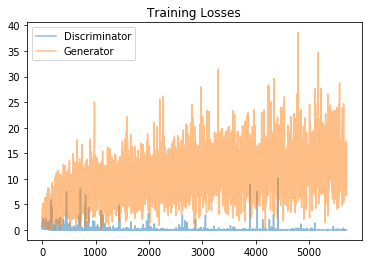

View Samples


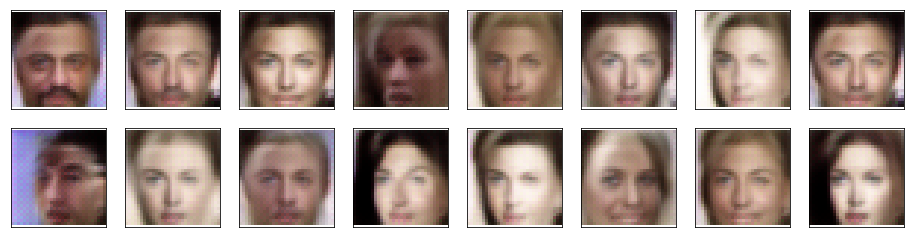

In [29]:
# tune hyperparameters by calling the training function in a loop
n_epochs=100
#for index, n_epochs in enumerate(number_epochs):
#for index, conv_dim in enumerate(conv_dim_set):
#for index, batch_size in enumerate(batch_size_set):
for index, lr in enumerate(lr_set):
    # Set Parameter
    n_epochs = n_epochs
    lr = lr
    batch_size = batch_size
    d_conv_dim = conv_dim
    g_conv_dim = conv_dim
    
    # Get dataloader
    celeba_train_loader = get_dataloader(batch_size, img_size)
    
    # Build network
    print('Build Network')
    D, G = build_network(d_conv_dim, g_conv_dim, z_size)
    
    # Reset optimizer
    d_optimizer, g_optimizer = optimizer(lr)
    
    # Calculate losses
    losses = train(D, G, n_epochs=n_epochs, index=index)
    
    # Save and Plot Data
    save_data(index, losses, batch_size)
    plot_training_loss(losses)
    _ = view_samples(index, epoch=-1)
    

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

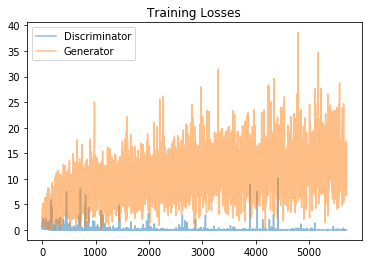

In [30]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [31]:
# helper function for viewing and a list of passed in sample images
def view_samples_2(epoch, samples, train_num):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    fig.savefig('image_sets/train_' + str(train_num) + '.png')

In [32]:
# helper function for viewing saving a list of stored training losses of the Discriminator and Generator
def view_plots(train_runs, title, param):
    number_of_pots = len(train_runs)
    train_run_list = [m[0] for m in train_runs]
    param_list = [m[1] for m in train_runs]
    epochs_calc = [m[2] for m in train_runs]
    
    ax_set = ('a' + str(m) for m in range(number_of_pots))
    
    fig, ax_set = plt.subplots(figsize=(16,4), nrows=1, ncols=number_of_pots)
    fig.suptitle(title)
    for ii,train_num in enumerate(train_run_list):
        df = pd.read_excel('training_results/train_' + str(train_num) + '_' + str(param_list[ii]) + '.xlsx')  # doctest: +SKIP
        loss_d = df['Discriminator'].values
        loss_g = df['Generator'].values
        ax_set[ii].plot(df.index/epochs_calc[ii], loss_d, label='Discriminator')
        ax_set[ii].plot(df.index/epochs_calc[ii], loss_g, label='Generator')
        ax_set[ii].set_title('Train_' + str(train_num))
        #ax_set[ii].xlabel('n_epochs', fontsize=14)
        #ax_set[iniidex].ylabel('loss', fontsize=14)
        ax_set[ii].legend()
        
    fig.savefig('plots/train_' + str(param) + '.png')

In the following section the parameter tuning which was investigated in separated training runs is appended. 

## Parameter: n_epochs

Parameters          | 1st Train-Run | 2nd Train-Run | 3rd Train-Run | 4th Train-Run | 5th Train-Run | 6th Train-Run |
----------          | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- |
batch_size          |   128         |   128         |   128         |   128         |   128         |   128         |
img_size            |   32          |   32          |   32          |   32          |   32          |   32          |
deconv-layers       |   3           |   3           |   3           |   3           |   3           |   3           |
conv-layers         |   3           |   3           |   3           |   3           |   3           |   3           |
d_conv_dim          |   32          |   32          |   32          |   32          |   32          |   32          |
g_conv_dim          |   32          |   32          |   32          |   32          |   32          |   32          |
z_size              |   100         |   100         |   100         |   100         |   100         |   100         |
lr                  |   0.001       |   0.001       |   0.001       |   0.001       |   0.001       |   0.001       |  
beta1               |   0.5         |   0.5         |   0.5         |   0.5         |   0.5         |   0.5         |
beta2               |   0.999       |   0.999       |   0.999       |   0.999       |   0.999       |   0.999       |
dropout             |   no          |   no          |   no          |   no          |   no          |   no          |
**n_epochs**        |   `1`         |   `10`        |   `50`        |   `100`       |   `500`       |   `1000`      |

In [33]:
# n_epochs = 1
train_num = 1
param = 'num_epochs'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

FileNotFoundError: [Errno 2] No such file or directory: 'image_sets/train_1.png'

In [ ]:
# n_epochs = 10
train_num = 2
param = 'num_epochs'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
# n_epochs = 50
train_num = 3
param = 'num_epochs'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
# n_epochs = 100
train_num = 4
param = 'num_epochs'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
# n_epochs = 500
train_num = 5
param = 'num_epochs'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
# n_epochs = 1000
train_num = 6
param = 'num_epochs'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
view_plots([[1, 'num_epochs', 3],
            [2, 'num_epochs', 3],
            [3, 'num_epochs', 3],
            [4, 'num_epochs', 3],
            [5, 'num_epochs', 3],
            [6, 'num_epochs', 3]], 'Number of epochs', 'n_epochs') 

### Result for parameter n_epochs:
Best value setting for the number of epochs extends to the range 50...100. Lower epoch values lead to underfitting, higher epoch values tend to pronounced noisy behavior of the discriminator loss. In both regimes the generated face images are blurred. In the following 100 epochs will be used for further parameter studies.

## Parameter: number of conv-layers and deconv-layers	

Parameters          | 4th Train-Run | 8th Train-Run | 
----------          | ------------- | ------------- |
batch_size          |   128         |   128         |  
img_size            |   32          |   32          | 
**deconv-layers**   |   `3`         |   `4`         |
**conv-layers**     |   `3`         |   `4`         | 
d_conv_dim          |   32          |   32          |
g_conv_dim          |   32          |   32          | 
z_size              |   100         |   100         |  
lr                  |   0.001       |   0.001       |  
beta1               |   0.5         |   0.5         | 
beta2               |   0.999       |   0.999       |
dropout             |   no          |   no          |
n_epochs            |   100         |   100         |

In [ ]:
# conv-layers=3 and deconv-layers=3
train_num = 4
param = 'num_epochs'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
# conv-layers=4 and deconv-layers=4
train_num = 8
param = 'conv_deconv'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
view_plots([[4, 'num_epochs', 3],
            [8, 'conv_deconv', 3]],'Number of conv- and deconv-layers', 'conv_deconv')  

### Result for parameter number of conv-layers and deconv-layers:
There is no clear trend with regard to the number of conv-layers and deconv-layers. Corresponding images for conv-layers=3 and deconv-layers=3 look similar to conv-layers=4 and deconv-layers=4. However, the trend of losses is slightly better for conv-layers=4 and deconv-layers=4, higher (positive) loss for the Generator and slightly lower loss for the Discriminator. In the following conv-layers=4 and deconv-layers=4 will be used for further parameter studies.

## Parameter: batch_size

Parameters          | 14th Train-Run | 15th Train-Run | 16th Train-Run  | 17th Train-Run |
----------          | ------------- | -------------   | -------------   | -------------  |
**batch_size**      |   `64`        |   `128`         |   `256`         |  `512`         |   
img_size            |   32          |   32            |   32            |   32           |
deconv-layers       |   4           |   4             |   4             |   4            |
conv-layers         |   4           |   4             |   4             |   4            |
d_conv_dim          |   32          |   32            |   32            |   32           |   
g_conv_dim          |   32          |   32            |   32            |   32           |
z_size              |   100         |   100           |   100           |   100          |   
lr                  |   0.001       |   0.001         |   0.001         |   0.001        |  
beta1               |   0.5         |   0.5           |   0.5           |   0.5          |
beta2               |   0.999       |   0.999         |   0.999         |   0.999        |
dropout             |   no          |   no            |   no            |   no           |
n_epochs            |   100         |   100           |   100           |   100          |

In [ ]:
# batch_size=64
train_num = 14
param = 'batch_size'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
# batch_size=128
train_num = 15
param = 'batch_size'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
# batch_size=256
train_num = 16
param = 'batch_size'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
# batch_size=512
train_num = 17
param = 'batch_size'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
view_plots([[14, 'batch_size', 5],
            [15, 'batch_size', 3],
            [16, 'batch_size', 2],
            [17, 'batch_size', 1]], 'Batch size', 'batch_size') 

#### Result for parameter batch_size:
A larger batch_size has a positive effect on the computational boost. However, if the batch_size is getting too high the feature resolution is getting worse. This can be clearly seen if one compares a batch_size of 512 with a batch_size of 128. For the further study a batch_size of 128 has been chosen.

## Parameter: conv_dim

Parameters          | 8th Train-Run | 11th Train-Run  | 12th Train-Run  | 13th Train-Run |
----------          | ------------- | -------------   | -------------   | -------------  |
batch_size          |   128         |   128           |   128           |  128           |   
img_size            |   32          |   32            |   32            |   32           |
deconv-layers       |   4           |   4             |   4             |   4            |
conv-layers         |   4           |   4             |   4             |   4            |
**d_conv_dim**      |   `32`        |   `64`          |   `128`         |  `256`         |   
**g_conv_dim**      |   `32`        |   `64`          |   `128`         |  `256`         |
z_size              |   100         |   100           |   100           |   100          |   
lr                  |   0.001       |   0.001         |   0.001         |   0.001        |  
beta1               |   0.5         |   0.5           |   0.5           |   0.5          |
beta2               |   0.999       |   0.999         |   0.999         |   0.999        |
dropout             |   no          |   no            |   no            |   no           |
n_epochs            |   100         |   100           |   100           |   100          |

In [ ]:
# d_conv_dim=32 and g_conv_dim=32
train_num = 8
param = 'conv_deconv'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
# d_conv_dim=64 and g_conv_dim=64
train_num = 11
param = 'conv_dim'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
# d_conv_dim=128 and g_conv_dim=128
train_num = 12
param = 'conv_dim'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
# d_conv_dim=256 and g_conv_dim=256
train_num = 13
param = 'conv_dim'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
view_plots([[8, 'conv_deconv', 3],
            [11, 'conv_dim', 3],
            [12, 'conv_dim', 3],
            [13, 'conv_dim', 3]], 'Size of conv_dim', 'conv_dim') 

#### Result for parameter conv_dim:
With a higher conv_dim for the Generator and the Discriminator the resolution of feature details is getting higher. For example, eyes are better resolved with a conv_dim=256 than with a conv_dim=32. However, even a conv_dim of 64 leads to convincing results.

### Parameter: lr

Parameters          | 21th Train-Run | 14th Train-Run  | 22th Train-Run |
----------          | ------------- | -------------   | -------------   |
batch_size          |   128         |   128           |   128           |   
img_size            |   32          |   32            |   32            |   
deconv-layers       |   4           |   4             |   4             |   
conv-layers         |   4           |   4             |   4             |   
d_conv_dim          |   64          |   64            |   64            |    
g_conv_dim          |   64          |   64            |   64            |   
z_size              |   100         |   100           |   100           |    
**lr**              |   `0.01`      |   `0.001`       |   `0.0001`      |   
beta1               |   0.5         |   0.5           |   0.5           |   
beta2               |   0.999       |   0.999         |   0.999         |   
dropout             |   no          |   no            |   no            |   
n_epochs            |   100         |   100           |   100           | 

In [ ]:
# lr=0.01
train_num = 21
param = 'lr'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
# lr=0.001
train_num = 14
param = 'batch_size'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
# lr=0.0001
train_num = 22
param = 'lr'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

In [ ]:
view_plots([[21, 'lr', 3],
            [14, 'batch_size', 3],
            [22, 'lr', 3]], 'Learning rate', 'lr')

#### Result for parameter lr:
Learning rates in the range between 0.01 and 0.0001 were tested. In all three cases the GAN is able to learn and generated fake images of faces are successfully constructed. However,  a learning rate of lr=0.001 or lr=0.0001 lead to a slightly better feature resolution than lr = 0.01.

### Final hyperparameter setting
The following table shows the best-of setting of the investigated parameter tuning.

Parameters          | 14th Train-Run|
----------          | ------------- |
batch_size          |   128         |  
img_size            |   32          |  
deconv-layers       |   4           |  
conv-layers         |   4           |  
d_conv_dim          |   64          |    
g_conv_dim          |   64          |  
z_size              |   100         |  
lr                  |   0.0001       |   
beta1               |   0.5         |   
beta2               |   0.999       |     
dropout             |   no          |   
n_epochs            |   100         | 

### Final fake image output

In [ ]:
# images for reasonable setting
train_num = 26
param = 'lr'
# plot pkl file

with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)

# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

### Corresponding loss for the final setting

In [ ]:
# loss for reasonable setting
train_num = 22
param = 'lr'
fig, ax = plt.subplots()
df = pd.read_excel('training_results/train_' + str(train_num) + '_' + str(param) + '.xlsx')  # doctest: +SKIP
loss_d = df['Discriminator'].values
loss_g = df['Generator'].values
plt.plot(df.index/3, loss_d, label='Discriminator')
plt.plot(df.index/3,loss_g, label='Generator')
plt.title("Train_22")
plt.legend()
fig.savefig('plots/train_22_single.png')

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Reasons for the chosen final hyperparameter setting:
A whole bunch of parameters setting were tested in sequences (see evaluation above). 

#### n_epochs:
n_epochs was varied between 1 and 1000. Its best value setting extends to the range 50...100. Lower epoch values lead to underfitting, higher epoch values tend to pronounced noisy behavior of the discriminator loss. For both extreme regimes the generated face images are blurred. Therefore n_epochs was set to 100.

#### number of conv-layers and deconv-layers:
Two models were constructed: one with 3 and another one with 4 conv and deconv layers for the discriminator and generator, respectively. Corresponding images for conv-layers=deconv-layers=3 look similar to conv-layers=deconv-layers=4. Hence, a clear trend is hard to distinguish in these examples. However, the trend of losses is slightly better for conv-layers=deconv-layers=4 than for conv-layers=deconv-layers=3, i.e. the loss for the Generator is higher and the loss for the Discriminator is slightly lower. Therefore conv-layers=4 and deconv-layers=4 have been used for further parameter studies.

#### batch_size:
The value range for the batch_size was chosen between 64 and 512. A larger batch_size has a positive effect on the computational boost. However, if the batch_size is getting too high the feature resolution is getting worse (more blurred). This can be clearly seen if one compares a batch_size of 512 with a batch_size of 128. Therefore a batch_size of 128 has been chosen. Up to a batch_size of 512 no out-of-memory errors were observed (getting critical for higher batch_sizes).

##### conv_dim:
The conv_dim value was investigated in the range between 32 and 256. With a higher conv_dim for the Generator and the Discriminator the resolution of feature details is getting higher. For example, eyes are better resolved with a conv_dim=256 than with a conv_dim=32. However, even a conv_dim of 64 leads to convincing results.

#### lr:
As learning rates 0.01, 0.01 and 0.0001 were tested. In all three cases the GAN is able to learn and generated fake images of faces successfully. However, lr=0.001 or lr=0.0001 lead to a slightly better feature resolution than lr = 0.01.

### Further improvements:
- To overcome the issue of a biased dataset (celebrity faces that are mostly white): one could add more images of non-white celebrity faces to get a more balanced dataset in the end.
    
- The model size is limited by the number of conv-layers and deconv-layers which was set to 4 in maximum. Higher values were not tested so far. Increasing the model size could especially enhance the feature extraction of the Discriminator. The adversarial Generator is then forced to produce images with better feature resolution.

- A further increase of the conv_dim could lead to better results. However, this would significantly increase the training time.

- The dataset images are 64x64x3 NumPy images. In the get_dataloader function I resized the images down to 32x32x3. This is the image size for the Discriminator input and the size of the Generator output. This resolution of the generated images is noisy. If one would keep width=64 and height=64 the images could resemble more the original ones. However, this would also increase the training duration.

- Regarding the optimizer strategy: For the Discriminator as well as for the Generator the same type of optimizer (Adam) was chosen with a learning rate down to 0.0001. A combination of different optimizer like SGD for the Discriminator and Adam for the Generator as proposed by [Soumith](https://github.com/soumith/ganhacks) has not been tested yet.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.